## 1. Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint
from tools.utils import download_data, get_sector_info, run_mean_reversion_analysis
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import math

c:\Users\QueLe\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


## 2. Functions

In [2]:
def rolling_beta(y, x, window=60):
    """
    Computes rolling hedge ratio (beta) using OLS.
    """
    betas = pd.Series(index=y.index, dtype='float64')
    for i in range(window, len(y)):
        yi = y.iloc[i - window:i]
        xi = x.iloc[i - window:i]
        if len(yi.dropna()) == window and len(xi.dropna()) == window:
            X = add_constant(xi)
            model = OLS(yi, X).fit()
            betas.iloc[i] = model.params[1]
    return betas.fillna(method='bfill')

def run_pair_trading_analysis(prices, max_pairs=50):
    tickers = prices.columns
    pairs_results = []
    spreads_dict = {}

    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            t1, t2 = tickers[i], tickers[j]
            y, x = prices[t1], prices[t2]
            y, x = y.dropna(), x.dropna()
            common_idx = y.index.intersection(x.index)
            y, x = y.loc[common_idx], x.loc[common_idx]

            if len(y) < 100:  # skip short series
                continue

            try:
                coint_pval = coint(y, x)[1]
                if coint_pval < 0.05:
                    # beta = np.polyfit(x, y, 1)[0]
                    beta = rolling_beta(y, x)
                    spread = y - beta * x
                    zscore = (spread - spread.mean()) / spread.std()
                    sharpe = (zscore.shift(1) * spread.diff()).mean() / (spread.diff().std() + 1e-8) * np.sqrt(252)

                    ticker_name = f"{t1}_{t2}"
                    pairs_results.append({
                        "Ticker": ticker_name,
                        "Stock1": t1,
                        "Stock2": t2,
                        "Cointegration p-value": round(coint_pval, 4),
                        "Sharpe (Z*ΔSpread)": round(sharpe, 4),
                        "Mean Spread": round(spread.mean(), 4),
                        "Std Spread": round(spread.std(), 4),
                        # "Start": spread.index.min(),
                        # "End": spread.index.max()
                    })
                    spreads_dict[ticker_name] = spread

            except Exception as e:
                print(f"Error processing pair ({t1}, {t2}): {e}")

    pair_results_df = pd.DataFrame(pairs_results)
    spread_series = {d["Ticker"]: spreads_dict[d["Ticker"]] for d in pairs_results}
    spread_df = pd.DataFrame(spread_series)
    
    return pair_results_df, spread_df


In [3]:
def benchmark_buy_and_hold(y, x, transaction_cost = 0.001):
    df = pd.concat([y, x], axis=1).dropna()
    daily_returns = df.diff().fillna(0)
    combined_returns = daily_returns.mean(axis=1)
    combined_returns.iloc[0] -= transaction_cost
    combined_returns.iloc[-1] -= transaction_cost
    cum_bench = combined_returns.cumsum()
    sharpe = combined_returns.mean() / (combined_returns.std() + 1e-8) * np.sqrt(252)
    # cum_bench = cum_bench - 2 * transaction_cost

    return {       
        "BuyHold Total Log Return": cum_bench.iloc[-1],
        "BuyHold Sharpe Ratio": sharpe,
        "BuyHold Cummulative Return": cum_bench,
    }

In [4]:
# Pair Trading Backtest Function
def backtest_pair_strategy(y, x, entry_z=1.5, exit_z=0.5, cost=0.001):
    # Align and regress to get spread
    df = pd.concat([y, x], axis=1).dropna()
    y, x = df.iloc[:, 0], df.iloc[:, 1]
    beta = rolling_beta(y, x)
    # beta = np.polyfit(x, y, 1)[0]
    spread = y - beta * x
    spread_mean = spread.rolling(60).mean().shift(-1) # to avoid lookahead bias
    spread_std = spread.rolling(60).std().shift(-1)
    zscore = (spread - spread_mean) / spread_std
    
    spread = spread.loc[zscore.index]
    beta = beta.loc[zscore.index]

    # Generate signals
    signals = pd.Series(0, index=spread.index)
    signals[zscore > entry_z] = -1  # Short spread
    signals[zscore < -entry_z] = 1  # Long spread
    signals[np.abs(zscore) < exit_z] = 0  # Exit

    # Forward fill signal positions
    positions = signals.replace(to_replace=0, method='ffill').shift(1).fillna(0)
    net_log_return = positions * spread.diff().fillna(0)
    trades = positions.diff().abs().fillna(0)
    costs = trades * cost
    net_log_return -= costs
    cum_log_return = net_log_return.cumsum()
    

    # Metrics
    sharpe = net_log_return.mean() / (net_log_return.std() + 1e-8) * np.sqrt(252)
    total_log_return = cum_log_return.iloc[-1]
    annualized_return = total_log_return * (252 / len(net_log_return))
    max_drawdown = (cum_log_return / cum_log_return.cummax() - 1).min()

    return {   
        "Total Log Return": total_log_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_drawdown,
        "Beta": beta,
        "Cummulative Return": cum_log_return
    }


In [5]:
def backtest_top_pairs(prices, pair_df, top_n=10):
    results = []
    for _, row in pair_df.head(top_n).iterrows():
        try:
            y = prices[row["Stock1"]]
            x = prices[row["Stock2"]]
            stats = backtest_pair_strategy(y, x)
            benchmark = benchmark_buy_and_hold(y, x)

            results.append({
                "Stock1": row["Stock1"],
                "Stock2": row["Stock2"],
                **stats,
                **benchmark
            })
        except Exception as e:
            print(f"Failed backtest for {row['Stock1']} & {row['Stock2']}: {e}")
    return pd.DataFrame(results)

In [6]:
def plot_top_pairs_grid(prices, pair_df, top_n=10, transaction_cost=0.001, title = "Top 10 Pair Trading Strategies: Cummulative Log Return"):
    n_rows = math.ceil(top_n / 2)
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=False)
    axes = axes.flatten()

    for idx, (_, row) in enumerate(pair_df.head(top_n).iterrows()):
        stock1, stock2 = row["Stock1"], row["Stock2"]
        y = prices[stock1]
        x = prices[stock2]

        # Use predefined strategy functions
        pair_stats = backtest_pair_strategy(y, x, cost=transaction_cost)
        bh_stats = benchmark_buy_and_hold(y, x, transaction_cost=transaction_cost)

        cum_strategy = pair_stats["Cummulative Return"]
        cum_bench = bh_stats["BuyHold Cummulative Return"]

        # Plot
        ax = axes[idx]
        ax.plot(cum_strategy, label="Pair Strategy", linewidth=2)
        ax.plot(cum_bench, label="Buy & Hold", linestyle="--", linewidth=2)
        ax.set_title(f"{stock1} vs {stock2}", fontsize=11)
        ax.legend()
        ax.grid(True)

    # Hide unused subplots
    for ax in axes[top_n:]:
        ax.set_visible(False)

    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f"../modelling_result/plots_{title}_{start_date[:4]}_{end_date[:4]}")
    plt.show()

In [7]:
def build_pair_metadata(pair_results_df, metadata_df):
    # Make metadata_df searchable
    meta = metadata_df.set_index("Stock")

    records = []
    for _, row in pair_results_df.iterrows():
        t1, t2 = row["Stock1"], row["Stock2"]
        ticker_pair = row["Ticker"]

        # Get sector/cap info safely
        sector1 = meta.loc[t1]["Sector"] if t1 in meta.index else "N/A"
        sector2 = meta.loc[t2]["Sector"] if t2 in meta.index else "N/A"
        industry1 = meta.loc[t1]["Industry"] if t1 in meta.index else "N/A"
        industry2 = meta.loc[t2]["Industry"] if t2 in meta.index else "N/A"
        cap1 = meta.loc[t1]["CapSize"] if t1 in meta.index else "N/A"
        cap2 = meta.loc[t2]["CapSize"] if t2 in meta.index else "N/A"

        records.append({
            "Ticker": ticker_pair,
            "Stock1": t1,
            "Stock2": t2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Industry1": industry1,
            "Industry2": industry2,
            "CapSize1": cap1,
            "CapSize2": cap2,
            # "CombinedSector": f"{sector1}_{sector2}"
        })

    return pd.DataFrame(records)

In [8]:
def add_metadata_to_pairs(df, metadata_df):
    """
    Adds sector/industry/cap size data for Stock1 and Stock2 to a pairs DataFrame.
    """
    # Merge metadata for Stock1
    df = df.merge(
        metadata_df[['Stock', 'Sector', 'Industry', 'CapSize']],
        left_on='Stock1',
        right_on='Stock',
        how='left'
    ).rename(columns={
        'Sector': 'Sector1',
        'Industry': 'Industry1',
        'CapSize': 'CapSize1'
    }).drop(columns='Stock')
    
    # Merge metadata for Stock2
    df = df.merge(
        metadata_df[['Stock', 'Sector', 'Industry', 'CapSize']],
        left_on='Stock2',
        right_on='Stock',
        how='left'
    ).rename(columns={
        'Sector': 'Sector2',
        'Industry': 'Industry2',
        'CapSize': 'CapSize2'
    }).drop(columns='Stock')
    
    # Add pair-level flags
    df['Same_Sector'] = df['Sector1'] == df['Sector2']
    df['Same_Industry'] = df['Industry1'] == df['Industry2']
    
    return df

In [9]:
def calculate_sector_industry_correlation_matrix(price_df, sector_etfs, industry_etfs, level='Sector'):
    ticker_to_sector = {v: k for k, v in sector_etfs.items()}
    ticker_to_industry = {v: k for k, v in industry_etfs.items()}
    if level == 'Sector':
        mapping = ticker_to_sector
    elif level == 'Industry':
        mapping = ticker_to_industry
    else:
        raise ValueError("level must be either 'Sector' or 'Industry'")

    # Select relevant ETFs
    common_cols = [col for col in price_df.columns if col in mapping]
    data = price_df[common_cols].copy()

    # Compute returns
    returns = data.pct_change().dropna()

    # Rename columns to descriptive names (Sector/Industry)
    returns.columns = [mapping[col] for col in returns.columns]

    # Compute correlation matrix
    corr_matrix = returns.corr()

    # Convert to long-form and clean
    correlation_df = corr_matrix.reset_index().melt(id_vars='index')
    correlation_df.columns = [f'{level}1', f'{level}2', f'{level} Correlation']
    correlation_df = correlation_df[correlation_df[f'{level}1'] != correlation_df[f'{level}2']]

    # Remove duplicate unordered pairs
    correlation_df['PairKey'] = correlation_df.apply(
        lambda row: frozenset([row[f'{level}1'], row[f'{level}2']]), axis=1
    )
    correlation_df = correlation_df.drop_duplicates(subset='PairKey').drop(columns='PairKey')

    return correlation_df


def add_correlation_column(pair_df, correlation_df, level='Sector'):
    df = pair_df.copy()

    # Dynamically assign key column names
    col1 = f"{level}1"
    col2 = f"{level}2"
    key_col = f"{level}PairKey"
    corr_col = f"{level} ETF Correlation"
    corr_cate_col = f"{level} Correlation Category"

    # Create unordered pair keys in both dataframes
    df[key_col] = df.apply(lambda row: frozenset([row[col1], row[col2]]), axis=1)
    correlation_df[key_col] = correlation_df.apply(lambda row: frozenset([row[col1], row[col2]]), axis=1)

    # Drop duplicates from correlation_df
    correlation_df = correlation_df.drop_duplicates(subset=key_col)

    # Create a lookup map from the correlation DataFrame
    corr_map = dict(zip(correlation_df[key_col], correlation_df[f'{level} Correlation']))
    df[corr_col] = df[key_col].map(corr_map)

    # Classify the correlation strength
    def classify_corr(corr):
        if pd.isna(corr):
            return 'Unknown'
        elif corr >= 0.7:
            return 'Highly Correlated'
        elif corr >= 0.3:
            return 'Moderately Correlated'
        elif corr <= -0.3:
            return 'Inversely Correlated'
        else:
            return 'Uncorrelated'

    df[corr_cate_col] = df[corr_col].apply(classify_corr)

    return df.drop(columns=key_col)


def plot_correlation_distribution(win_df, lose_df, level='Industry', save_path=None):
    corr_col = f"{level} ETF Correlation"

    sns.set(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    sns.histplot(win_df[corr_col], ax=axes[0], kde=True, color='salmon')
    axes[0].set_title(f'{level} Correlation Distribution in Win Cases')

    sns.histplot(lose_df[corr_col], ax=axes[1], kde=True, color='salmon')
    axes[1].set_title(f'{level} Correlation Distribution in Lose Cases')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


## 3. Parameters

In [10]:
start_date = '2010-01-01'
end_date = '2019-12-31'
large_cap_tickers = ['AAPL', 'MSFT', 'JPM', 'GOOGL', 'XOM', 'JNJ', 'UNH', 'PG', 'V', 'MA', 'HD', 'COST', 'AVGO', 'LLY', 'BAC', 'MRK', 'ADBE']
mid_cap_tickers = ['TFX', 'HES', 'WU', 'CHDN', 'CROX','FICO', 'ROK', 'LII', 'WDC', 'MTCH',
       'MKC', 'CLF', 'FE', 'AKAM', 'TXT', 'REG']
small_cap_tickers = ['INSM', 'NEOG', 'ACLS', 'PRDO', 'IMMR', 'CVCO',  'STRL', 'TPC', 'GHC', 'FIZZ',  'CMTL', 'MGEE',  'CRVL', 'CVGW', 'CLW', 'AMSC', 'BBY']
tickers = large_cap_tickers + mid_cap_tickers + small_cap_tickers

In [11]:
prices = download_data(tickers, start_date, end_date)
prices.head()

Failed to get ticker 'CHDN' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'V' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'ROK' reason: Expecting value: line 1 column 1 (char 0)
[***                    6%%                      ]  3 of 50 completedFailed to get ticker 'JPM' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'NEOG' reason: Expecting value: line 1 column 1 (char 0)
[****                   8%%                      ]  4 of 50 completedFailed to get ticker 'CVGW' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'UNH' reason: Expecting value: line 1 column 1 (char 0)
[*****                 10%%                      ]  5 of 50 completedFailed to get ticker 'WDC' reason: Expecting value: line 1 column 1 (char 0)
[*****                 10%%                      ]  5 of 50 completedFailed to get ticker 'MA' reason: Expecting value: line 1 column 1 (char 0)
[*******               14%%    

Yahoo Finance returned no data. Falling back to local CSV.


,AAPL,MSFT,JPM,GOOGL,XOM,JNJ,UNH,PG,V,MA,...,TPC,GHC,FIZZ,CMTL,MGEE,CRVL,CVGW,CLW,AMSC,BBY
0,1.861269,3.144645,3.361388,2.747899,3.652442,3.712929,3.222706,3.662285,2.981593,3.164680,...,2.880637,5.365737,1.260585,3.156317,2.791282,1.701409,2.505661,3.301745,6.043820,3.208256
1,1.862997,3.144968,3.380573,2.743486,3.656339,3.701265,3.221119,3.662612,2.970068,3.161716,...,2.901366,5.368628,1.235893,3.154628,2.761193,1.687941,2.496954,3.323056,6.052560,3.233319
2,1.846963,3.138812,3.386052,2.717954,3.664945,3.709366,3.230918,3.657858,2.956549,3.160269,...,2.924762,5.370003,1.212228,3.150392,2.760622,1.663926,2.513678,3.328268,6.060757,3.225524
3,1.845112,3.128358,3.405667,2.694399,3.661797,3.702203,3.268577,3.652420,2.965812,3.153713,...,2.981692,5.392476,1.202269,3.165278,2.760337,1.681759,2.509986,3.368674,6.067731,3.241295
4,1.851739,3.135231,3.403208,2.707642,3.657778,3.705635,3.259142,3.651097,2.968574,3.154068,...,3.005674,5.392476,1.201435,3.196295,2.766603,1.678342,2.539748,3.340562,6.073505,3.201265


In [12]:
etf_sector_tickers = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU']
sector_etfs = {
    'Consumer Cyclical': 'XLY',
    'Consumer Defensive': 'XLP',
    'Financial Services': 'XLF',
    'Healthcare': 'XLV',
    'Industrials': 'XLI',
    'Technology': 'XLK',
    'Utilities': 'XLU',
    'Real Estate': 'XLRE',
    'Energy': 'XLE',
    'Basic Materials': 'XLB',
    'Communication Services': 'XLC',
}



industry_etfs = {
    'Consumer Electronics': 'FDN',
    'Software - Infrastructure': 'WCLD',  # WCLD is a better fit for cloud/software infra
    'Banks - Diversified': 'KBE',
    'Semiconductors': 'SOXX',
    'Oil & Gas Integrated': 'XLE',
    'Drug Manufacturers - General': 'PJP',
    'Healthcare Plans': 'IHF',
    'Household & Personal Products': 'XLP',
    'Credit Services': 'IPAY',
    'Home Improvement Retail': 'XRT',
    'Discount Stores': 'XLY',
    'Software - Application': 'IGV',  # IGV better reflects app software
    'Internet Content & Information': 'FDN',
    'Internet Retail': 'IBUY',
    'Medical Instruments & Supplies': 'IHI',
    'Oil & Gas E&P': 'XOP',
    'Specialty Retail': 'RETL',
    'Specialty Industrial Machinery': 'XAR',
    'Building Products & Equipment': 'PKB',
    'Restaurants': 'PBI',  # Assuming a placeholder; no perfect ETF, could also use 'EATZ'
    'Gambling': 'BJK',
    'Footwear & Accessories': 'XLY',
    'Computer Hardware': 'IYW',
    'Packaged Foods': 'PBJ',
    'Steel': 'SLX',
    'Utilities - Regulated Electric': 'XLU',
    'REIT - Retail': 'VNq',
    'Diagnostics & Research': 'ARKG',
    'REIT - Industrial': 'FREL',
    'Biotechnology': 'XBI',
    'Semiconductor Equipment & Materials': 'SMH',
    'Education & Training Services': 'TAL',
    'Residential Construction': 'ITB',
    'Engineering & Construction': 'PAVE',
    'Beverages - Non-Alcoholic': 'PBJ',
    'Communication Equipment': 'VOX',
    'Insurance Brokers': 'KIE',
    'Food Distribution': 'PBJ',
    'Paper & Paper Products': 'WOOD',
    'Auto Part': 'CARZ'
}

In [13]:
# metadata
ticker_cap_mapping = {ticker: 'Large' for ticker in large_cap_tickers}
ticker_cap_mapping.update({ticker: 'Mid' for ticker in mid_cap_tickers})
ticker_cap_mapping.update({ticker: 'Small' for ticker in small_cap_tickers})

# sector_df = get_sector_info(tickers)
# sector_df['CapSize'] = sector_df['Ticker'].map(ticker_cap_mapping)
# metadata_df = sector_df[['Ticker', 'Sector', 'Industry', 'CapSize']]
metadata_df = pd.read_csv("../data_prices/metadata.csv")
metadata_df = metadata_df.rename(columns={'Ticker': 'Stock'})
metadata_df

,Stock,Sector,Industry,CapSize
0,AAPL,Technology,Consumer Electronics,Large
1,MSFT,Technology,Software - Infrastructure,Large
2,JPM,Financial Services,Banks - Diversified,Large
3,NVDA,Technology,Semiconductors,Large
4,XOM,Energy,Oil & Gas Integrated,Large
5,JNJ,Healthcare,Drug Manufacturers - General,Large
6,UNH,Healthcare,Healthcare Plans,Large
7,PG,Consumer Defensive,Household & Personal Products,Large
8,V,Financial Services,Credit Services,Large
9,MA,Financial Services,Credit Services,Large


## 4. Analysis

In [14]:
# Cointegration analysis
pair_results_df, pair_spread = run_pair_trading_analysis(prices)
# pair_results_df = pd.read_csv(f"../modelling_result/pair_trading_top_cointegrated_pairs_{start_date[:4]}_{end_date[:4]}.csv")
# pair_spread = pd.read_csv(f"../modelling_result/pair_trading_spread_series_{start_date[:4]}_{end_date[:4]}.csv")
pair_results_df.to_csv(f"../modelling_result/pair_trading_top_cointegrated_pairs_{start_date[:4]}_{end_date[:4]}.csv", index=False)
pair_spread.to_csv(f"../modelling_result/pair_trading_spread_series_{start_date[:4]}_{end_date[:4]}.csv", index=False)

In [15]:
pair_results_df

,Ticker,Stock1,Stock2,Cointegration p-value,Sharpe (Z*ΔSpread),Mean Spread,Std Spread
0,AAPL_MSFT,AAPL,MSFT,0.0375,-0.5366,-0.0048,3.1880
1,AAPL_MRK,AAPL,MRK,0.0423,-0.7304,1.7681,3.6327
2,AAPL_WU,AAPL,WU,0.0413,-0.6416,2.1045,2.0425
3,AAPL_CVCO,AAPL,CVCO,0.0340,-0.7039,2.2236,2.2118
4,MSFT_ADBE,MSFT,ADBE,0.0189,-0.6132,1.5556,1.9577
...,...,...,...,...,...,...,...
79,NEOG_CVGW,NEOG,CVGW,0.0136,-0.6423,1.4094,2.7262
80,ACLS_BBY,ACLS,BBY,0.0064,-0.7059,1.0774,3.0198
81,IMMR_AMSC,IMMR,AMSC,0.0344,-0.7259,1.5206,1.7406
82,CVCO_MGEE,CVCO,MGEE,0.0365,-0.6883,1.7769,4.2340


In [16]:
pair_spread

,AAPL_MSFT,AAPL_MRK,AAPL_WU,AAPL_CVCO,MSFT_ADBE,MSFT_TFX,MSFT_FICO,MSFT_CVCO,JPM_ADBE,JPM_TFX,...,TXT_NEOG,TXT_CVCO,TXT_CVGW,INSM_GHC,NEOG_CVCO,NEOG_CVGW,ACLS_BBY,IMMR_AMSC,CVCO_MGEE,CVCO_CVGW
0,-1.290377,0.437007,1.899171,0.085411,1.023592,2.935912,2.833664,1.874396,-0.260547,1.083723,...,1.781549,0.126736,0.761447,-2.015661,-0.770642,-0.682472,2.076389,-0.124841,0.702114,2.420001
1,-1.288974,0.436849,1.900830,0.102831,1.014339,2.936815,2.834882,1.885944,-0.257713,1.109229,...,1.779972,0.132290,0.749843,-2.017847,-0.775769,-0.701725,2.064988,-0.118553,0.701585,2.392166
2,-1.298838,0.414582,1.884788,0.104268,1.009431,2.930119,2.828396,1.892285,-0.250105,1.108813,...,1.821106,0.193929,0.769671,-2.018887,-0.761456,-0.729378,2.118650,-0.099591,0.666539,2.348493
3,-1.290211,0.411989,1.883451,0.083328,1.010479,2.919168,2.817847,1.868176,-0.210848,1.123015,...,1.857706,0.207481,0.816374,-2.035878,-0.778119,-0.714670,2.126816,-0.093092,0.705783,2.389212
4,-1.290473,0.418862,1.890234,0.073530,1.020543,2.925722,2.824909,1.863300,-0.207858,1.117078,...,1.864956,0.191057,0.800157,-2.035878,-0.798581,-0.740861,2.192712,-0.080207,0.732734,2.408430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,-3.584946,-3.051412,1.014590,-3.832600,1.039233,-0.107046,2.040257,0.740614,0.125186,-1.570498,...,5.998335,6.710422,1.869283,23.972238,0.086056,3.229339,-2.487703,0.781463,5.148353,5.406966
2511,-3.420034,-2.760044,1.017120,-2.963749,1.083628,-0.072294,2.018873,1.008904,0.241957,-1.430212,...,5.945537,6.402162,2.142533,22.805810,-0.285306,3.171811,-2.368010,0.775803,4.946234,5.145612
2512,-3.293399,-2.607938,1.004841,-2.309202,1.125171,-0.048848,1.999557,1.326036,0.354771,-1.333686,...,6.128664,6.173045,2.546504,21.843177,-0.456615,3.383813,-2.227105,0.745653,4.897884,5.108067
2513,-3.230693,-2.552344,0.965817,-1.619753,1.161686,-0.030527,1.992905,1.708515,0.464917,-1.228434,...,6.066052,6.003981,2.835089,20.196091,-0.458667,3.360096,-2.102266,0.706157,4.842120,5.099709


### 4.1. Statistical test on spreads

In [17]:
# Statistical Mean Reversion Analysis
pair_metadata_df = build_pair_metadata(pair_results_df, metadata_df)
pair_metadata_df

,Ticker,Stock1,Stock2,Sector1,Sector2,Industry1,Industry2,CapSize1,CapSize2
0,AAPL_MSFT,AAPL,MSFT,Technology,Technology,Consumer Electronics,Software - Infrastructure,Large,Large
1,AAPL_MRK,AAPL,MRK,Technology,Healthcare,Consumer Electronics,Drug Manufacturers - General,Large,Large
2,AAPL_WU,AAPL,WU,Technology,Financial Services,Consumer Electronics,Credit Services,Large,Mid
3,AAPL_CVCO,AAPL,CVCO,Technology,Consumer Cyclical,Consumer Electronics,Residential Construction,Large,Small
4,MSFT_ADBE,MSFT,ADBE,Technology,Technology,Software - Infrastructure,Software - Application,Large,Large
...,...,...,...,...,...,...,...,...,...
79,NEOG_CVGW,NEOG,CVGW,Healthcare,Consumer Defensive,Diagnostics & Research,Food Distribution,Small,Small
80,ACLS_BBY,ACLS,BBY,Technology,Consumer Cyclical,Semiconductor Equipment & Materials,Specialty Retail,Small,Small
81,IMMR_AMSC,IMMR,AMSC,Technology,Industrials,Software - Application,Specialty Industrial Machinery,Small,Small
82,CVCO_MGEE,CVCO,MGEE,Consumer Cyclical,Utilities,Residential Construction,Utilities - Regulated Electric,Small,Small


In [18]:
stat_df = run_mean_reversion_analysis(pair_spread, pair_metadata_df, strategy_type="spread")
stat_df

,Ticker,ADF p-value,Hurst,Half-life,Volatility,Stock1,Stock2,Sector1,Sector2,Industry1,Industry2,CapSize1,CapSize2
0,AAPL_MSFT,0.0,0.2516,284.7807,0.2295,AAPL,MSFT,Technology,Technology,Consumer Electronics,Software - Infrastructure,Large,Large
1,AAPL_MRK,0.0,0.3636,155.5472,0.3517,AAPL,MRK,Technology,Healthcare,Consumer Electronics,Drug Manufacturers - General,Large,Large
2,AAPL_WU,0.0,0.4892,208.3823,0.1681,AAPL,WU,Technology,Financial Services,Consumer Electronics,Credit Services,Large,Mid
3,AAPL_CVCO,0.0,0.5288,170.7350,0.2024,AAPL,CVCO,Technology,Consumer Cyclical,Consumer Electronics,Residential Construction,Large,Small
4,MSFT_ADBE,0.0,0.4414,232.8308,0.1509,MSFT,ADBE,Technology,Technology,Software - Infrastructure,Software - Application,Large,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,NEOG_CVGW,0.0,0.4440,212.9080,0.2193,NEOG,CVGW,Healthcare,Consumer Defensive,Diagnostics & Research,Food Distribution,Small,Small
80,ACLS_BBY,0.0,0.3315,167.5757,0.2808,ACLS,BBY,Technology,Consumer Cyclical,Semiconductor Equipment & Materials,Specialty Retail,Small,Small
81,IMMR_AMSC,0.0,0.4176,171.2874,0.1540,IMMR,AMSC,Technology,Industrials,Software - Application,Specialty Industrial Machinery,Small,Small
82,CVCO_MGEE,0.0,0.4073,180.2125,0.3755,CVCO,MGEE,Consumer Cyclical,Utilities,Residential Construction,Utilities - Regulated Electric,Small,Small


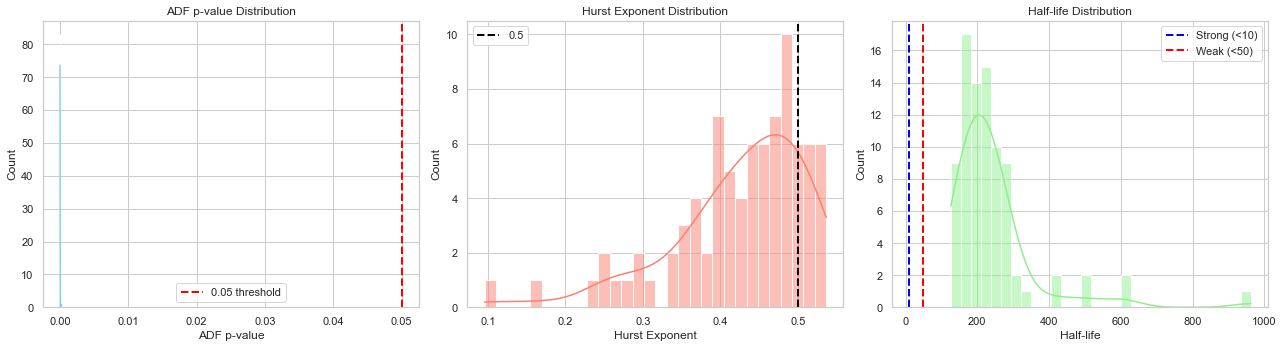

In [19]:
# Plotting histograms for ADF p-value, Hurst exponent, and Half-life
df = stat_df.copy()

# Set style
sns.set(style='whitegrid')

# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for ADF p-value with threshold
sns.histplot(df['ADF p-value'], bins=10, kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(0.05, color='red', linestyle='--', linewidth=2, label='0.05 threshold')
axes[0].set_title('ADF p-value Distribution')
axes[0].set_xlabel('ADF p-value')
axes[0].legend()

# Histogram for Hurst exponent with thresholds
sns.histplot(df['Hurst'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='0.5')
axes[1].set_title('Hurst Exponent Distribution')
axes[1].set_xlabel('Hurst Exponent')
axes[1].legend()

# Histogram for Half-life with thresholds
sns.histplot(df['Half-life'], bins=30, kde=True, ax=axes[2], color='lightgreen')
axes[2].axvline(10, color='blue', linestyle='--', linewidth=2, label='Strong (<10)')
axes[2].axvline(50, color='red', linestyle='--', linewidth=2, label='Weak (<50)')
axes[2].set_title('Half-life Distribution')
axes[2].set_xlabel('Half-life')
axes[2].legend()

# Final layout
plt.tight_layout()
plt.savefig(f"../modelling_result/plots_spread_distribution")
plt.show()

### 4.2. Backtesting strategy

In [20]:
# Backtesting
# pair_backtest_df = backtest_top_pairs(prices, pair_results_df, top_n=84)
# pair_backtest_df.to_csv(f"../modelling_result/pair_trading_backtest_results_{start_date[:4]}_{end_date[:4]}.csv", index=False)
pair_backtest_df = pd.read_csv(f"../modelling_result/pair_trading_backtest_results_{start_date[:4]}_{end_date[:4]}.csv")
pair_backtest_df['Ticker'] = pair_backtest_df['Stock1'] + '_' + pair_backtest_df['Stock2']

In [21]:
# Divide into winning group and losing group
win = pair_backtest_df[(pair_backtest_df['Total Log Return'] > pair_backtest_df['BuyHold Total Log Return']) & (pair_backtest_df['Sharpe Ratio'] > pair_backtest_df['BuyHold Sharpe Ratio']) & (pair_backtest_df['Sharpe Ratio'] > 0)]
lose = pair_backtest_df[~pair_backtest_df.index.isin(win.index)]

In [22]:
win.describe()

c:\Users\QueLe\anaconda3\lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\QueLe\anaconda3\lib\site-packages\numpy\lib\function_base.py:4575: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


,Total Log Return,Annualized Return,Sharpe Ratio,Max Drawdown,BuyHold Total Log Return,BuyHold Sharpe Ratio
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,46.817529,4.691061,1.035495,-inf,1.587920,0.737183
std,42.951209,4.303660,0.316603,NaN,0.721676,0.373654
min,10.838806,1.086035,0.626101,-inf,-0.325075,-0.087059
25%,18.345602,1.838207,0.761073,NaN,1.390082,0.548883
50%,38.537689,3.861430,1.033025,-inf,1.588066,0.775957
75%,53.451673,5.355794,1.290953,-8.274091,1.956075,0.963640
max,167.478739,16.781170,1.619704,-1.378915,2.694568,1.213668


In [23]:
lose.describe()

c:\Users\QueLe\anaconda3\lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Total Log Return,Annualized Return,Sharpe Ratio,Max Drawdown,BuyHold Total Log Return,BuyHold Sharpe Ratio
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,11.531068,1.155399,0.416363,-inf,1.993945,0.965064
std,9.221687,0.924002,0.321833,NaN,0.282732,0.197048
min,-8.548022,-0.856502,-0.328992,-inf,1.270908,0.489437
25%,3.171258,0.317756,0.110429,NaN,1.807764,0.833986
50%,12.927675,1.295338,0.500897,NaN,2.014973,0.951832
75%,19.161990,1.920008,0.695224,NaN,2.152496,1.150433
max,29.301087,2.935934,0.877318,-10.071245,2.658201,1.256768


In [24]:
top10 = win.sort_values('Sharpe Ratio', ascending=False).head(10)
bottom10 = lose.sort_values('Sharpe Ratio', ascending=True).head(10)

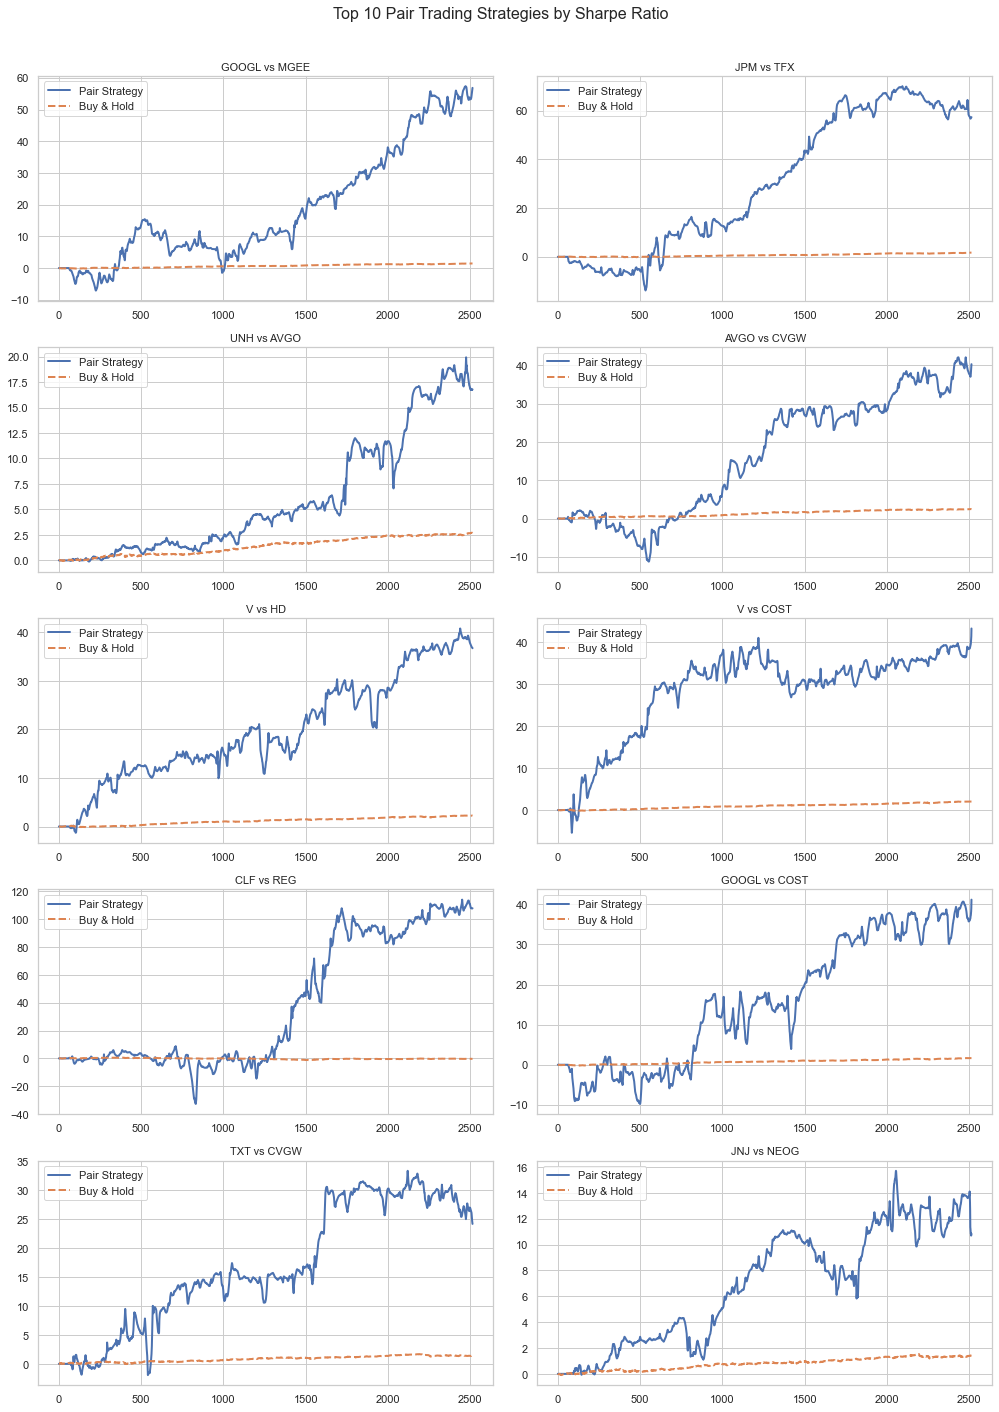

In [25]:
plot_top_pairs_grid(prices, top10, top_n=10, title = "Top 10 Pair Trading Strategies by Sharpe Ratio", transaction_cost=0.001)

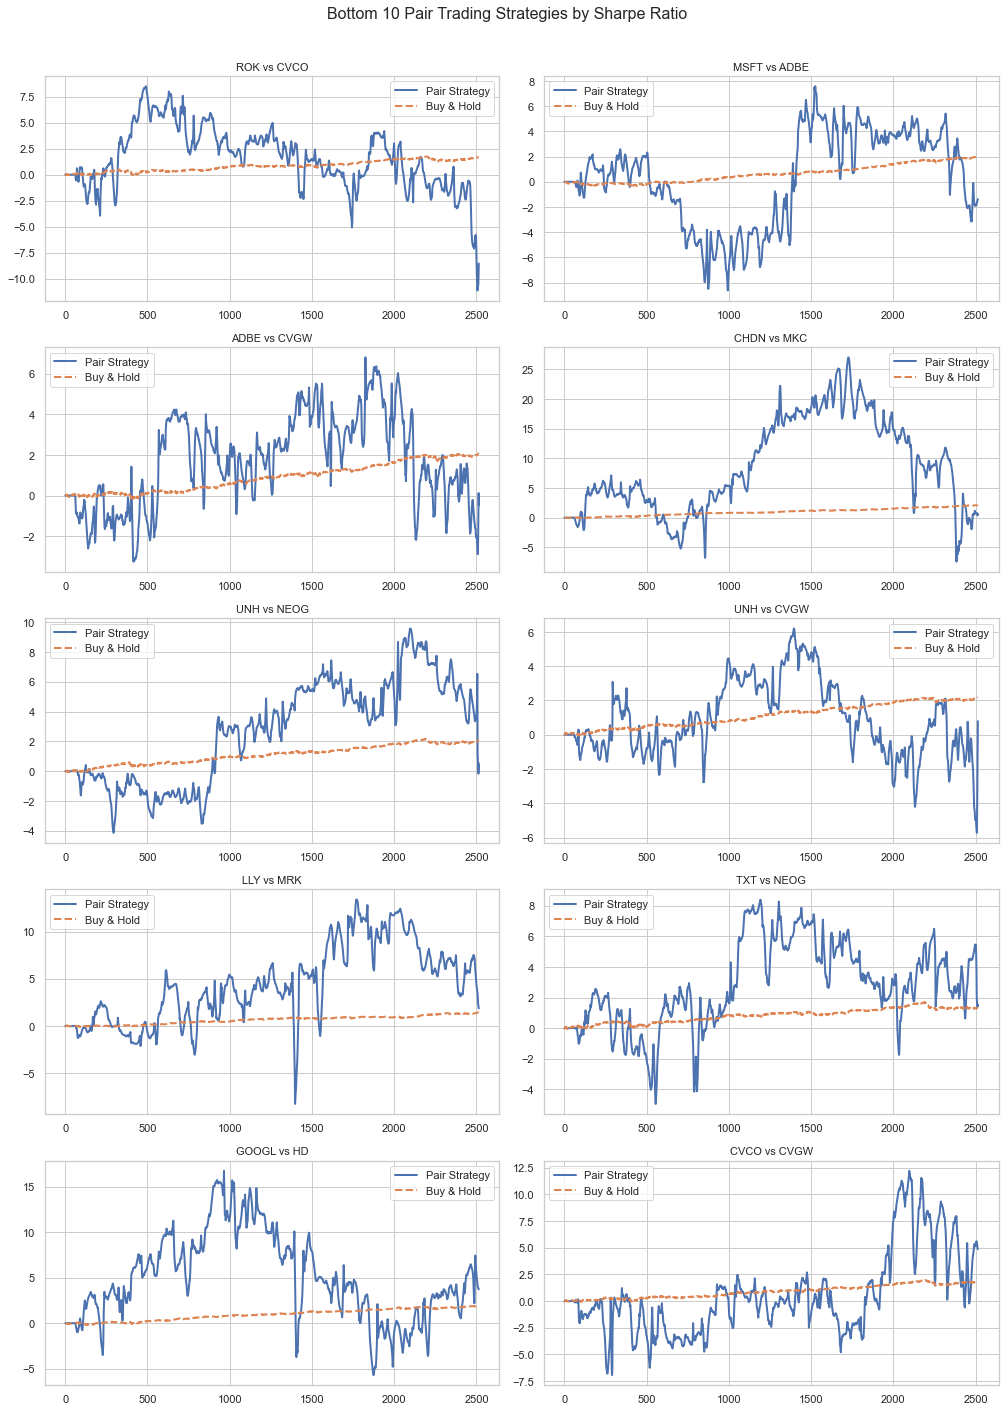

In [26]:
plot_top_pairs_grid(prices, bottom10, top_n=10, title = "Bottom 10 Pair Trading Strategies by Sharpe Ratio", transaction_cost=0.001)

#### a. Sector and Industry Analysis

In [27]:
# Sector and Industry Correlation Analysis
# etf_sector_data = yf.download(etf_sector_tickers, start='2010-01-01', end='2019-12-31', auto_adjust=True)['Close']
# etf_industry_data = yf.download(etf_industry_tickers, start='2010-01-01', end='2019-12-31', auto_adjust=True)['Close']
etf_sector_data = pd.read_csv(f"../data_prices/etf_sector_data_{start_date[:4]}_{end_date[:4]}.csv")
etf_industry_data = pd.read_csv(f"../data_prices/etf_industry_data_{start_date[:4]}_{end_date[:4]}.csv")

# etf_sector_data['Close'].to_csv(f"../data_prices/etf_sector_data_{start_date[:4]}_{end_date[:4]}.csv")
# etf_industry_data['Close'].to_csv(f"../data_prices/etf_industry_data_{start_date[:4]}_{end_date[:4]}.csv")
etf_sector_data = etf_sector_data.fillna(method='bfill')
etf_industry_data = etf_industry_data.fillna(method='bfill')


sector_correlation_df = calculate_sector_industry_correlation_matrix(etf_sector_data, sector_etfs, industry_etfs, level='Sector')
industry_correlation_df = calculate_sector_industry_correlation_matrix(etf_industry_data, sector_etfs, industry_etfs, level='Industry')

In [28]:
# stat_df
redundant_cols = ['Sector1', 'Sector2', 'Industry1', 'Industry2', 'CapSize1', 'CapSize2']
stat_df = stat_df.drop(columns=redundant_cols, errors='ignore')

In [29]:
win_with_metadata = add_metadata_to_pairs(win, metadata_df)
lose_with_metadata = add_metadata_to_pairs(lose, metadata_df)

win_with_metadata['label'] = 'Win'
lose_with_metadata['label'] = 'Lose'

In [30]:
# Sector
win_with_corr_sector = add_correlation_column(win_with_metadata, sector_correlation_df, level='Sector')
lose_with_corr_sector = add_correlation_column(lose_with_metadata, sector_correlation_df, level='Sector')

# merge with stat_df
lose_with_corr_sector = lose_with_corr_sector.merge(stat_df[['Ticker', 'ADF p-value', 'Hurst', 'Half-life', 'Volatility']], on='Ticker', how='left')
win_with_corr_sector = win_with_corr_sector.merge(stat_df[['Ticker', 'ADF p-value', 'Hurst', 'Half-life', 'Volatility']], on='Ticker', how='left')

In [31]:
# Industry
win_with_corr_industry = add_correlation_column(win_with_metadata, industry_correlation_df, level='Industry')
lose_with_corr_industry = add_correlation_column(lose_with_metadata, industry_correlation_df, level='Industry')

# merge with stat_df
lose_with_corr_industry['Ticker'] = lose_with_corr_industry['Stock1'] + '_' + lose_with_corr_industry['Stock2']
lose_with_corr_industry = lose_with_corr_industry.merge(stat_df, on='Ticker', how='left')
win_with_corr_industry['Ticker'] = win_with_corr_industry['Stock1'] + '_' + win_with_corr_industry['Stock2']
win_with_corr_industry = win_with_corr_industry.merge(stat_df, on='Ticker', how='left')

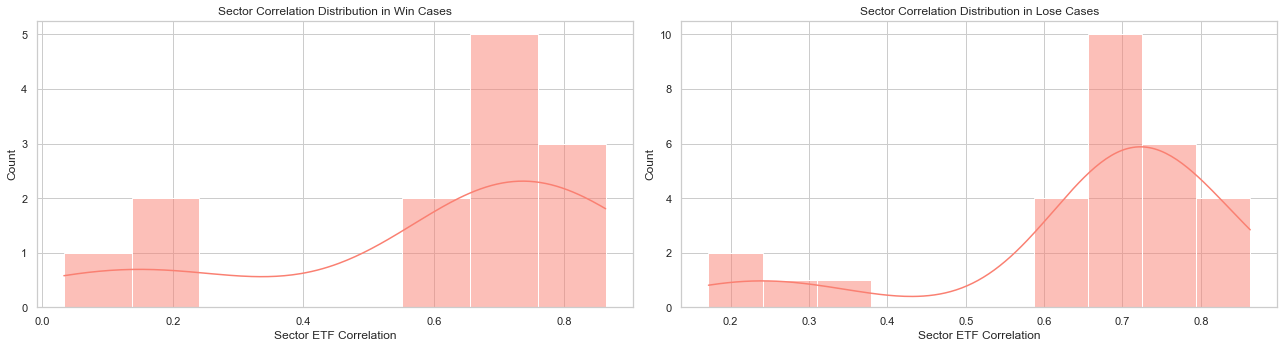

In [32]:
plot_correlation_distribution(win_with_corr_sector, lose_with_corr_sector, level='Sector',
                              save_path="../modelling_result/plot_etf_sector_distribution.png")

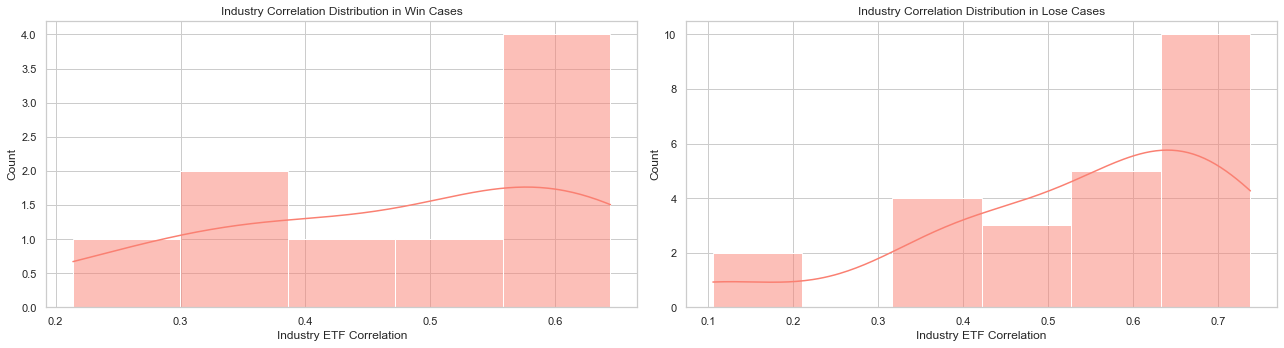

In [33]:
plot_correlation_distribution(win_with_corr_industry, lose_with_corr_industry, level='Industry',
                              save_path="../modelling_result/plot_etf_industry_distribution.png")

In [34]:
# Create combined table for sector
combined_table = pd.DataFrame({
    ('Winning cases', 'Total Log Return'): win_with_corr_sector['Total Log Return'].describe(),
    ('Winning cases', 'Sharpe Ratio'): win_with_corr_sector['Sharpe Ratio'].describe(),
    ('Winning cases', 'Sector Correlation'): win_with_corr_sector['Sector ETF Correlation'].describe(),
    # ('Winning cases', 'Industry Correlation'): win_with_corr_industry['Industry ETF Correlation'].describe(),
    ('Losing cases', 'Total Log Return'): lose_with_corr_sector['Total Log Return'].describe(),
    ('Losing cases', 'Sharpe Ratio'): lose_with_corr_sector['Sharpe Ratio'].describe(),
    ('Losing cases', 'Sector Correlation'): lose_with_corr_sector['Sector ETF Correlation'].describe(),
    # ('Losing cases', 'Industry Correlation'): lose_with_corr_industry['Industry ETF Correlation'].describe(),
})


combined_table

Winning cases                                     Losing cases  \
      Total Log Return Sharpe Ratio Sector Correlation Total Log Return   
count        14.000000    14.000000          13.000000        34.000000   
mean         46.817529     1.035495           0.598858        11.531068   
std          42.951209     0.316603           0.274329         9.221687   
min          10.838806     0.626101           0.033230        -8.548022   
25%          18.345602     0.761073           0.631582         3.171258   
50%          38.537689     1.033025           0.698255        12.927675   
75%          53.451673     1.290953           0.757574        19.161990   
max         167.478739     1.619704           0.863018        29.301087   

                                       
      Sharpe Ratio Sector Correlation  
count    34.000000          28.000000  
mean      0.416363           0.660752  
std       0.321833           0.183636  
min      -0.328992           0.171826  
25%       0.110429           0.651063  
50%       0.500897           0.704326  
75%       0.695224           0.759077  
max       0.877318           0.863018

In [35]:
# Create combined table for industry
combined_table = pd.DataFrame({
    ('Winning cases', 'Total Log Return'): win_with_corr_sector['Total Log Return'].describe(),
    ('Winning cases', 'Sharpe Ratio'): win_with_corr_sector['Sharpe Ratio'].describe(),
    ('Winning cases', 'Sector Correlation'): win_with_corr_sector['Sector ETF Correlation'].describe(),
    # ('Winning cases', 'Industry Correlation'): win_with_corr_industry['Industry ETF Correlation'].describe(),
    ('Losing cases', 'Total Log Return'): lose_with_corr_sector['Total Log Return'].describe(),
    ('Losing cases', 'Sharpe Ratio'): lose_with_corr_sector['Sharpe Ratio'].describe(),
    ('Losing cases', 'Sector Correlation'): lose_with_corr_sector['Sector ETF Correlation'].describe(),
    # ('Losing cases', 'Industry Correlation'): lose_with_corr_industry['Industry ETF Correlation'].describe(),
})


combined_table

Winning cases                                     Losing cases  \
      Total Log Return Sharpe Ratio Sector Correlation Total Log Return   
count        14.000000    14.000000          13.000000        34.000000   
mean         46.817529     1.035495           0.598858        11.531068   
std          42.951209     0.316603           0.274329         9.221687   
min          10.838806     0.626101           0.033230        -8.548022   
25%          18.345602     0.761073           0.631582         3.171258   
50%          38.537689     1.033025           0.698255        12.927675   
75%          53.451673     1.290953           0.757574        19.161990   
max         167.478739     1.619704           0.863018        29.301087   

                                       
      Sharpe Ratio Sector Correlation  
count    34.000000          28.000000  
mean      0.416363           0.660752  
std       0.321833           0.183636  
min      -0.328992           0.171826  
25%       0.110429           0.651063  
50%       0.500897           0.704326  
75%       0.695224           0.759077  
max       0.877318           0.863018

#### b. Technical Analysis

In [36]:
def compute_spread_volatility(price1, price2):
    spread = price1 - price2
    return spread.std()

def compute_liquidity_ratio(volume1, volume2):
    return (volume1 / volume2).mean()

def compute_volatility_ratio(price1, price2):
    returns1 = price1.pct_change().dropna()
    returns2 = price2.pct_change().dropna()
    return returns1.std() / returns2.std()


def analyze_technical_features(pair_df, price_df, volume_df):
    """
    price_data_dict: dict of {ticker: price_series}
    volume_data_dict: dict of {ticker: volume_series}
    """
    results = []
    
    for idx, row in pair_df.iterrows():
        s1, s2 = row['Stock1'], row['Stock2']
        p1, p2 = price_df[s1].reset_index(drop=True), price_df[s2].reset_index(drop=True)
        v1, v2 = volume_df[s1].reset_index(drop=True), volume_df[s2].reset_index(drop=True)

        # Align by date
        df = pd.concat([p1, p2, v1, v2], axis=1).dropna()
        price1, price2 = df.iloc[:,0], df.iloc[:,1]
        vol1, vol2 = df.iloc[:,2], df.iloc[:,3]

        spread_volatility = compute_spread_volatility(price1, price2)
        liquidity_diff = compute_liquidity_ratio(vol1, vol2)
        volatility_ratio = compute_volatility_ratio(price1, price2)

        results.append({
            'Stock1': s1,
            'Stock2': s2,
            'Spread_Volatility': spread_volatility,
            'Liquidity_Diff': liquidity_diff,
            'Volatility_Ratio': volatility_ratio
        })

    return pd.DataFrame(results)


In [37]:
volume_df = pd.read_csv(f"../data_prices/volume_2010_2019.csv")

In [38]:
# Create combined table for technical features
win_technical = analyze_technical_features(win_with_metadata, prices, volume_df)
lose_technical = analyze_technical_features(lose_with_metadata, prices, volume_df)
win_stats = win_technical.describe()
lose_stats = lose_technical.describe()
combined_table = pd.DataFrame({
    ('Winning cases', 'Spread_Volatility'): win_stats['Spread_Volatility'],
    ('Winning cases', 'Liquidity_Diff'): win_stats['Liquidity_Diff'],
    ('Winning cases', 'Volatility_Ratio'): win_stats['Volatility_Ratio'],
    ('Losing cases', 'Spread_Volatility'): lose_stats['Spread_Volatility'],
    ('Losing cases', 'Liquidity_Diff'): lose_stats['Liquidity_Diff'],
    ('Losing cases', 'Volatility_Ratio'): lose_stats['Volatility_Ratio'],
})

# Format infinity and NaN values
combined_table = combined_table.replace([np.inf, -np.inf], 'inf')
combined_table = combined_table.fillna('NaN')

combined_table

Winning cases                                      Losing cases  \
      Spread_Volatility Liquidity_Diff Volatility_Ratio Spread_Volatility   
count         14.000000           14.0        14.000000         34.000000   
mean           0.297302            inf         2.349031          0.215492   
std            0.301900            NaN         2.832391          0.074590   
min            0.099082       0.389567         0.145031          0.096384   
25%            0.157435       7.728083         0.814635          0.163015   
50%            0.218931        38.6204         1.338096          0.207262   
75%            0.291155     314.459572         1.900031          0.249633   
max            1.307646            inf         8.713010          0.400317   

                                       
      Liquidity_Diff Volatility_Ratio  
count      34.000000        34.000000  
mean       73.515069         0.919569  
std       223.845011         0.402619  
min         0.183937         0.377921  
25%         3.184869         0.601576  
50%         7.697936         0.826949  
75%        39.830878         1.133230  
max      1288.097168         2.062800